In [1]:
import pandas as pd
import numpy as np

In [2]:
%run data_cleaning.ipynb
%run data_exploration.ipynb

Total number of rows:  8554
Total number of columns:  20


# Data Visualization

### Setting-up

In [3]:
from plotnine import *
import matplotlib.pyplot as plt 
# import matplotlib.dates as mdates
# from mizani.formatters import percent_format
import seaborn as sns 
import datetime
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

*Observation with an unexpected ticket price is removed from the dataset, as it may significantly influence statistics such as mean.*

In [4]:
dataset=dataset.loc[(dataset.ticket_price<6000)].reset_index()

*Create a column for the booking date and convert to datetime (day_scrap, hour_scrap)*

In [5]:
cur_time = datetime.datetime.now()
month = cur_time.strftime('%b')
year = cur_time.strftime('%Y')

In [6]:
dataset['date']=pd.to_datetime(dataset['day_scrap'].astype(str) + ' ' + month + ' ' + year + ' '+ dataset['hour_scrap'].astype(str), format='%d %b %Y %H')

*Calculate total duration of round trip*

In [7]:
dataset['tot_duration'] = dataset["out_duration"] + dataset["in_duration"]

In [8]:
dataset

,index,out_airline_company,in_airline_company,dep_city,arr_city,out_dep_date,out_dep_time,out_duration,out_stop_num,out_arr_date,...,in_duration,in_stop_num,in_arr_date,in_arr_time,hour_scrap,day_scrap,ticket_price,currency,date,tot_duration
0,0,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,09:35,0 days 11:25:00,1,2023-08-01,...,0 days 09:40:00,1,2023-08-16,07:35,16,20,1176.01,€,2023-05-20 16:00:00,0 days 21:05:00
1,1,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,13:15,0 days 12:50:00,1,2023-08-01,...,0 days 16:20:00,1,2023-08-16,15:50,16,20,923.39,€,2023-05-20 16:00:00,1 days 05:10:00
2,2,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,08:50,0 days 12:10:00,1,2023-08-01,...,0 days 09:40:00,1,2023-08-16,07:35,16,20,1176.01,€,2023-05-20 16:00:00,0 days 21:50:00
3,3,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,09:35,0 days 11:25:00,1,2023-08-01,...,0 days 10:40:00,1,2023-08-16,08:35,16,20,1176.01,€,2023-05-20 16:00:00,0 days 22:05:00
4,4,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,09:35,0 days 11:25:00,1,2023-08-01,...,0 days 10:50:00,1,2023-08-16,10:20,16,20,1176.01,€,2023-05-20 16:00:00,0 days 22:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8542,8549,Swiss,Swiss,BRU,GRU,2023-08-01,09:15,1 days 01:10:00,2,2023-08-02,...,0 days 14:30:00,1,2023-08-16,14:15,8,29,1944.57,€,2023-05-29 08:00:00,1 days 15:40:00
8543,8550,Swiss,Swiss,BRU,GRU,2023-08-01,09:15,1 days 01:10:00,2,2023-08-02,...,0 days 14:30:00,1,2023-08-16,14:15,8,29,1944.57,€,2023-05-29 08:00:00,1 days 15:40:00
8544,8551,Swiss,Swiss,BRU,GRU,2023-08-01,20:15,0 days 14:10:00,1,2023-08-02,...,1 days 09:00:00,1,2023-08-17,08:45,8,29,1799.66,€,2023-05-29 08:00:00,1 days 23:10:00
8545,8552,Swiss,Swiss,BRU,GRU,2023-08-01,20:15,0 days 14:10:00,1,2023-08-02,...,0 days 22:45:00,2,2023-08-16,22:30,8,29,2094.57,€,2023-05-29 08:00:00,1 days 12:55:00


## a. Bar chart

#### a1. Number of flights by destination and airline company

In [9]:
barplot1 = dataset.groupby(["arr_city", "out_airline_company"]).size().reset_index(name="N")
barplot1["group_count"] = barplot1.groupby("arr_city")["N"].transform("sum")
barplot1['percent']=barplot1['N']/barplot1["group_count"]
barplot1

,arr_city,out_airline_company,N,group_count,percent
0,GRU,Lufthansa,2282,4095,0.557265
1,GRU,Swiss,1813,4095,0.442735
2,JFK,Lufthansa,2035,4452,0.457098
3,JFK,Swiss,2417,4452,0.542902


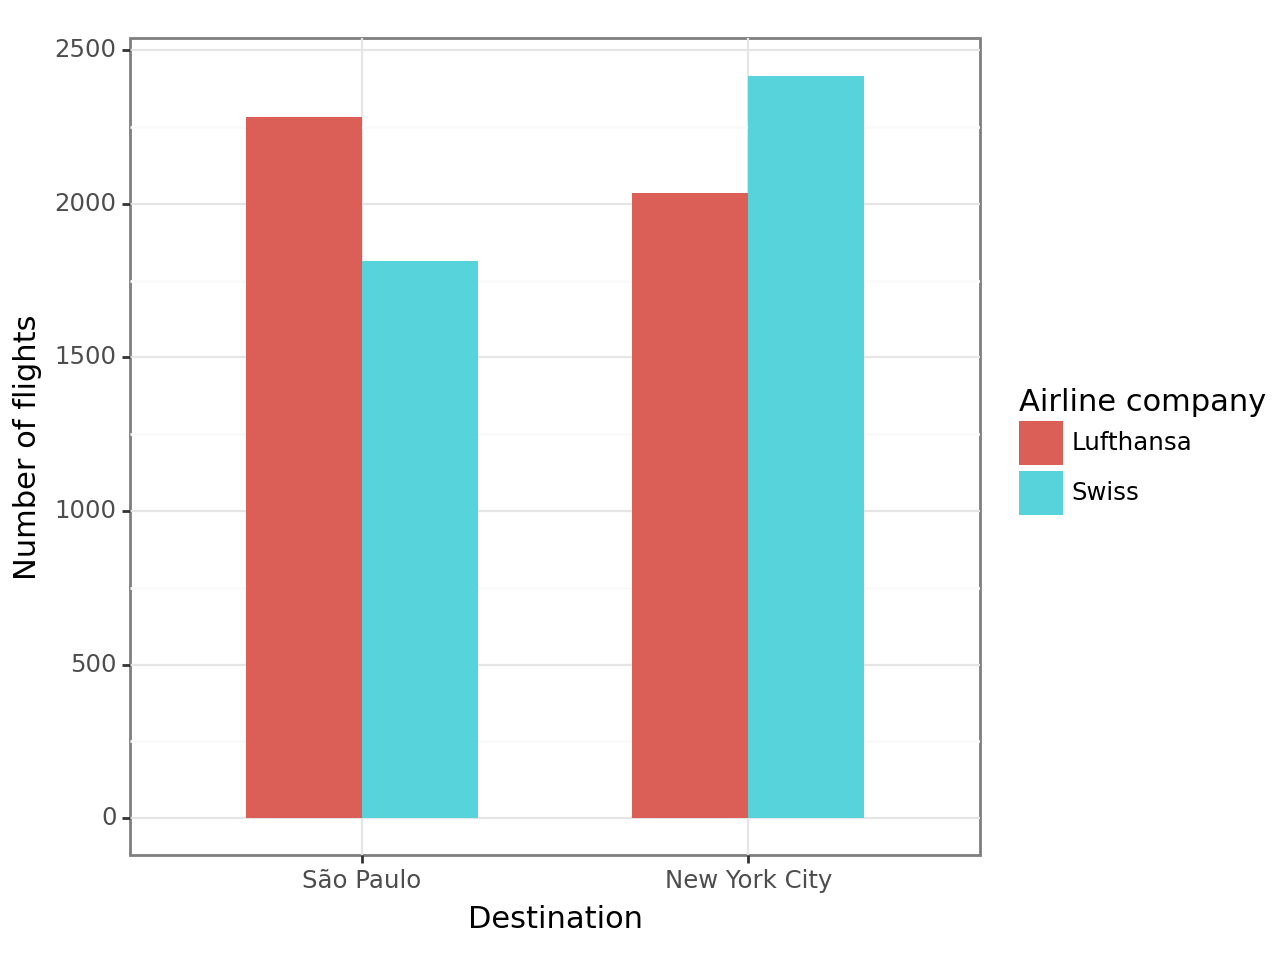

<Figure Size: (640 x 480)>

In [10]:
f1= (ggplot(barplot1, aes(x="arr_city", y="N", fill="out_airline_company"))
+ geom_bar(stat="identity", position="dodge", width=0.6, size=0.5)
+ labs(x="Destination", y="Number of flights", fill="Airline company")
+ scale_x_discrete(labels=["São Paulo", "New York City"])
+ theme_bw()
)
f1

#### a2. Ticket prices (min) based on the day of the week

In [11]:
barplot2=dataset.filter(['date','ticket_price','arr_city'])

In [12]:
barplot2['day_of_week'] = dataset['date'].dt.strftime('%A')

In [13]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
barplot2['day_of_week'] = pd.Categorical(barplot2['day_of_week'], categories=weekday_order, ordered=True)

In [14]:
barplot2

,date,ticket_price,arr_city,day_of_week
0,2023-05-20 16:00:00,1176.01,JFK,Saturday
1,2023-05-20 16:00:00,923.39,JFK,Saturday
2,2023-05-20 16:00:00,1176.01,JFK,Saturday
3,2023-05-20 16:00:00,1176.01,JFK,Saturday
4,2023-05-20 16:00:00,1176.01,JFK,Saturday
...,...,...,...,...
8542,2023-05-29 08:00:00,1944.57,GRU,Monday
8543,2023-05-29 08:00:00,1944.57,GRU,Monday
8544,2023-05-29 08:00:00,1799.66,GRU,Monday
8545,2023-05-29 08:00:00,2094.57,GRU,Monday


In [15]:
min_prices = barplot2.groupby(['day_of_week','arr_city'])['ticket_price'].min().reset_index()

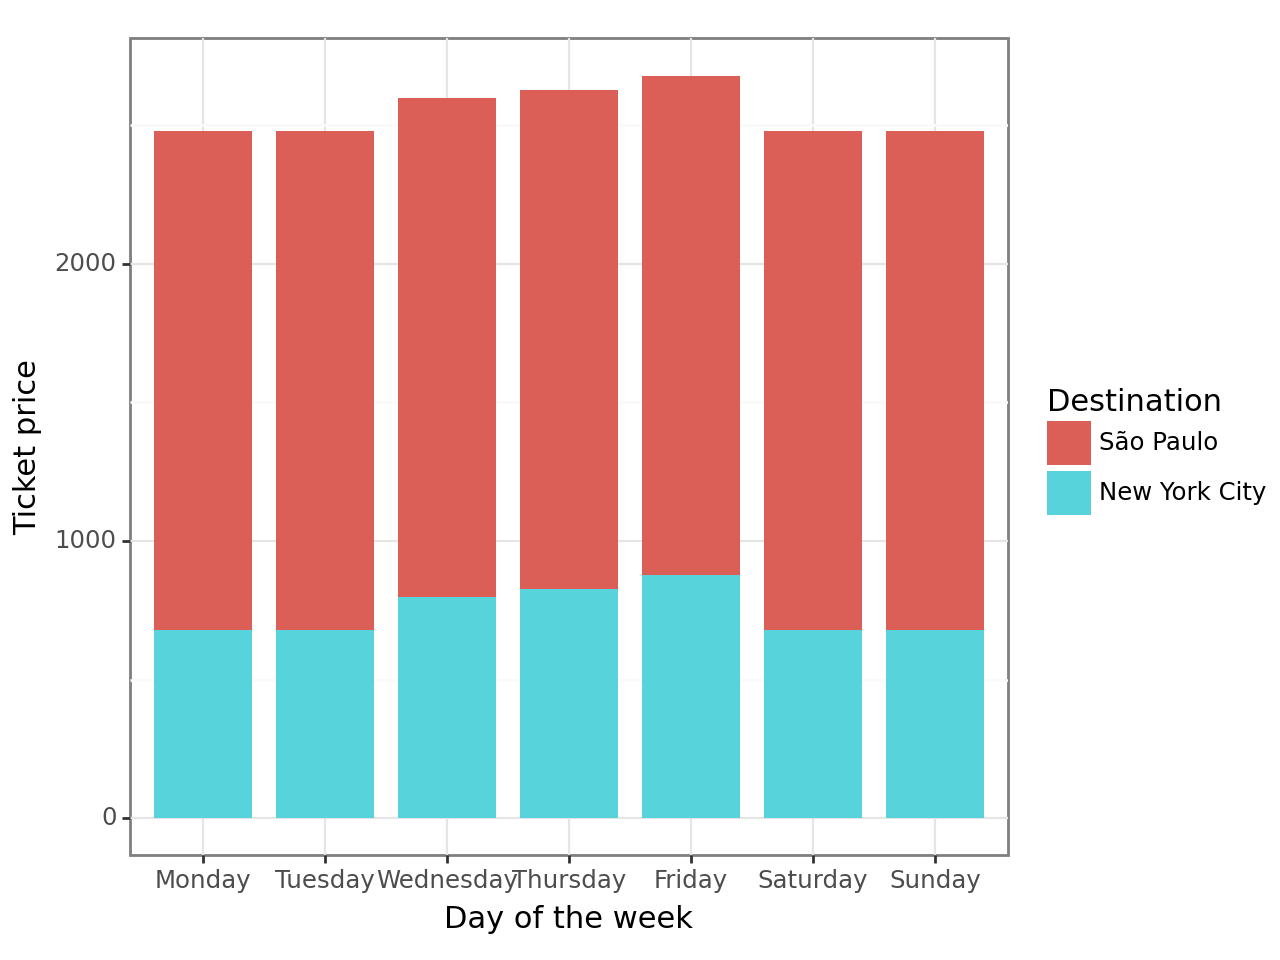

<Figure Size: (640 x 480)>

In [16]:
f1= (ggplot(min_prices, aes(x='day_of_week', y="ticket_price", fill='arr_city'))
+ geom_bar(stat="identity", position="stack", width=0.8, size=0.9)
+ labs(x="Day of the week", y="Ticket price", fill="Destination")
+ scale_fill_discrete(labels=["São Paulo", "New York City"])
+ theme_bw()
)
f1

### b. boxplot

In [17]:
lufthansa_nyc = nyc.loc[(nyc.out_airline_company == 'Lufthansa')]
swiss_nyc = nyc.loc[(nyc.out_airline_company == 'Swiss')]
lufthansa_sao = sao.loc[(sao.out_airline_company == 'Lufthansa')]
swiss_sao = sao.loc[(sao.out_airline_company == 'Swiss')]

##### b1. boxplots for New York City

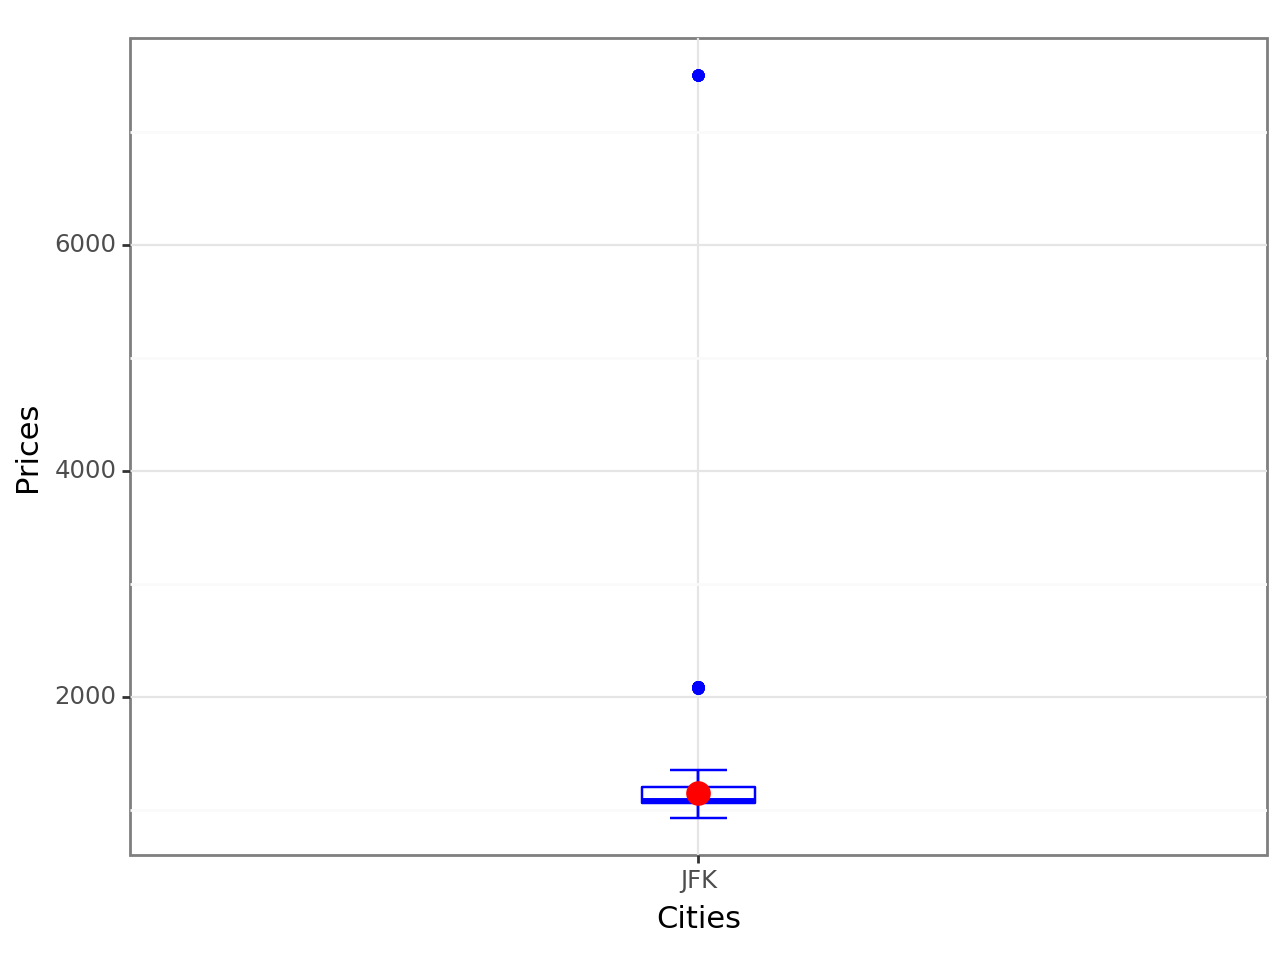

<Figure Size: (640 x 480)>

In [18]:
# Lufthasa
f2 = (
    ggplot(lufthansa_nyc, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f2

f2 = f2 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f2

f2 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

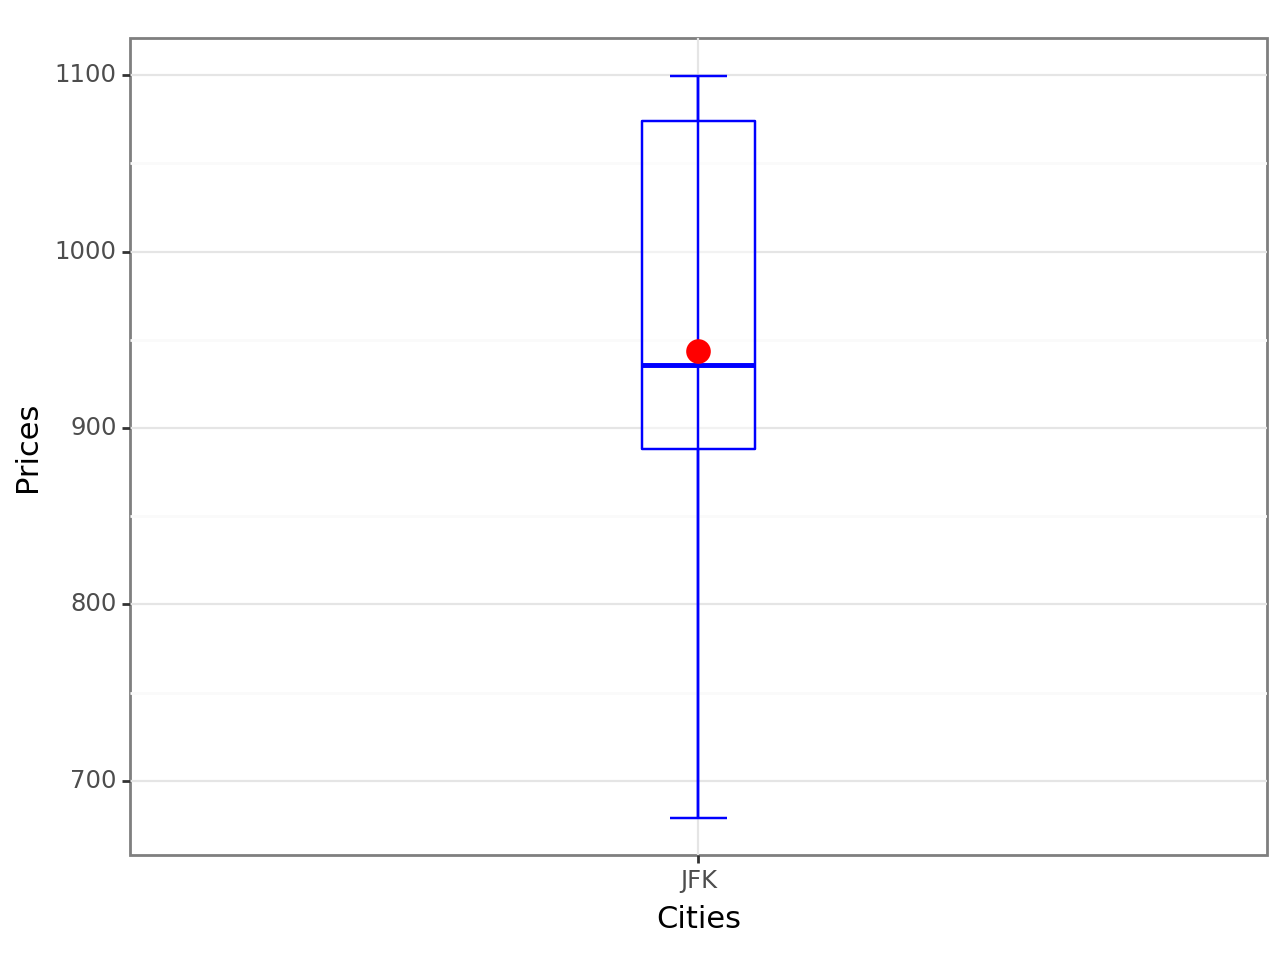

<Figure Size: (640 x 480)>

In [19]:
# Swiss
f3 = (
    ggplot(swiss_nyc, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f3

f3 = f3 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f3

f3 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

##### b2. boxplots for São Paulo destination

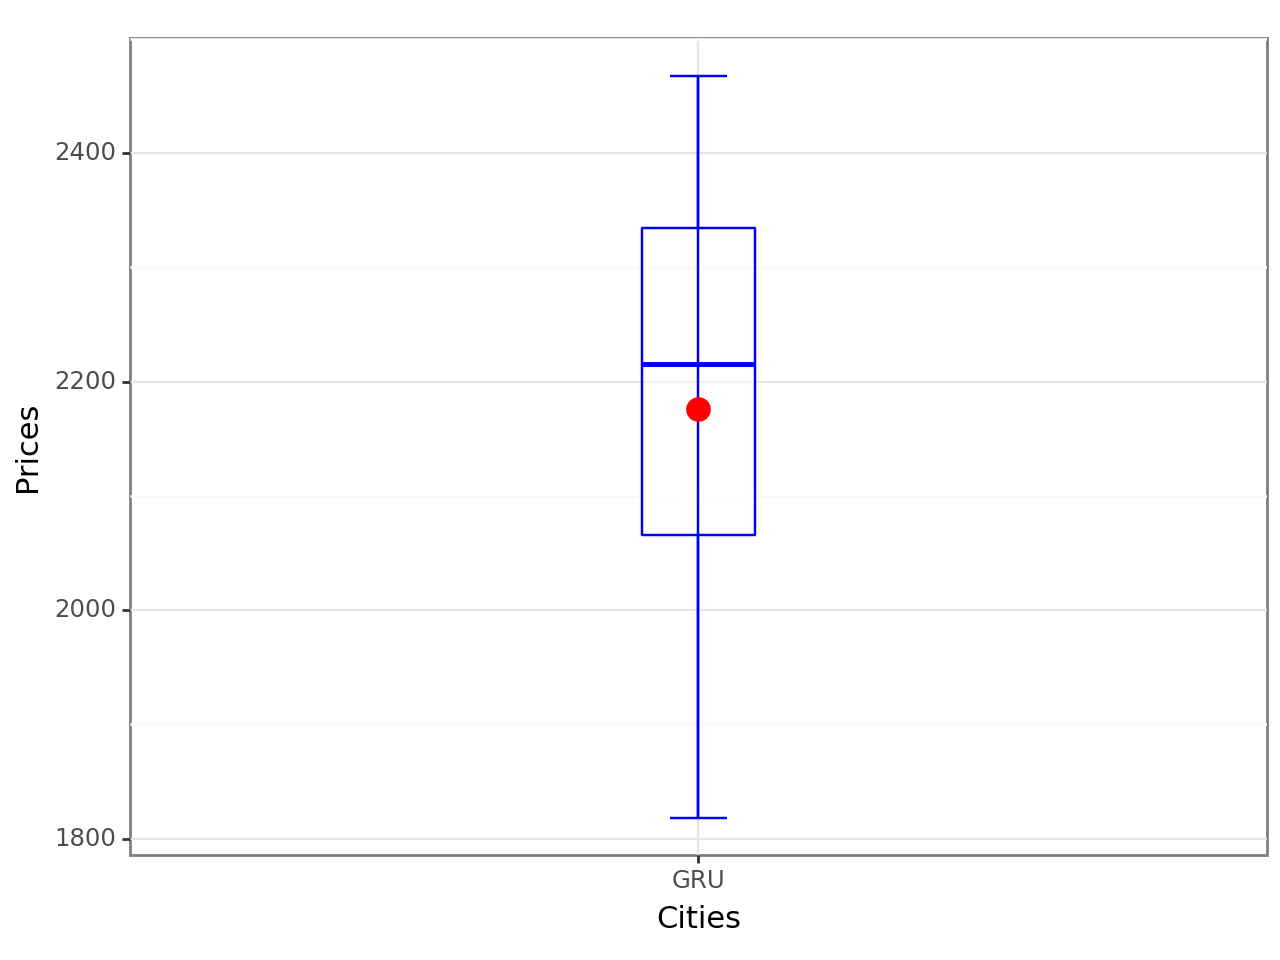

<Figure Size: (640 x 480)>

In [20]:
# Lufthasa
f4 = (
    ggplot(lufthansa_sao, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f4

f4 = f4 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f4

f4 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

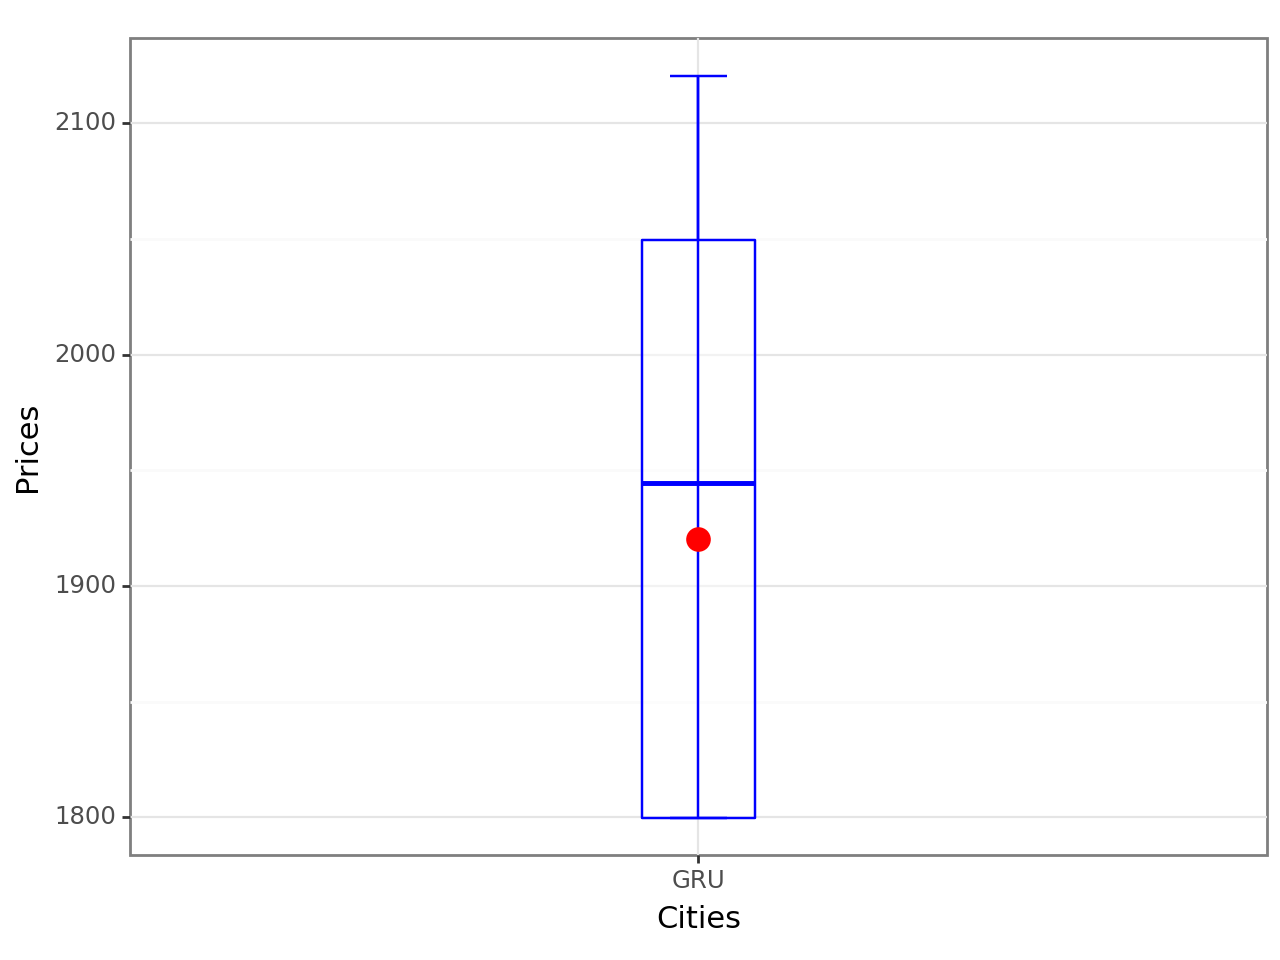

<Figure Size: (640 x 480)>

In [21]:
# Swiss
f5 = (
    ggplot(swiss_sao, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f5

f5 = f5 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f5

f5 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

## c. Lineplot

In [22]:
lineplot=dataset.filter(['date', 'arr_city','out_airline_company','ticket_price'])
lineplot['day_booking']=lineplot['date'].dt.strftime('%d %b')


#### c1. Lineplot for New York City based on booking day

In [23]:
lineplot_nyc=lineplot.loc[(lineplot.arr_city=='JFK')].groupby(['day_booking','out_airline_company'])['ticket_price'].min()
lineplot_nyc=lineplot_nyc.reset_index()

In [24]:
date_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Lufthansa']['day_booking'].tolist()
price_lufthansa_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Lufthansa']['ticket_price'].tolist()
price_swiss_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Swiss']['ticket_price'].tolist()

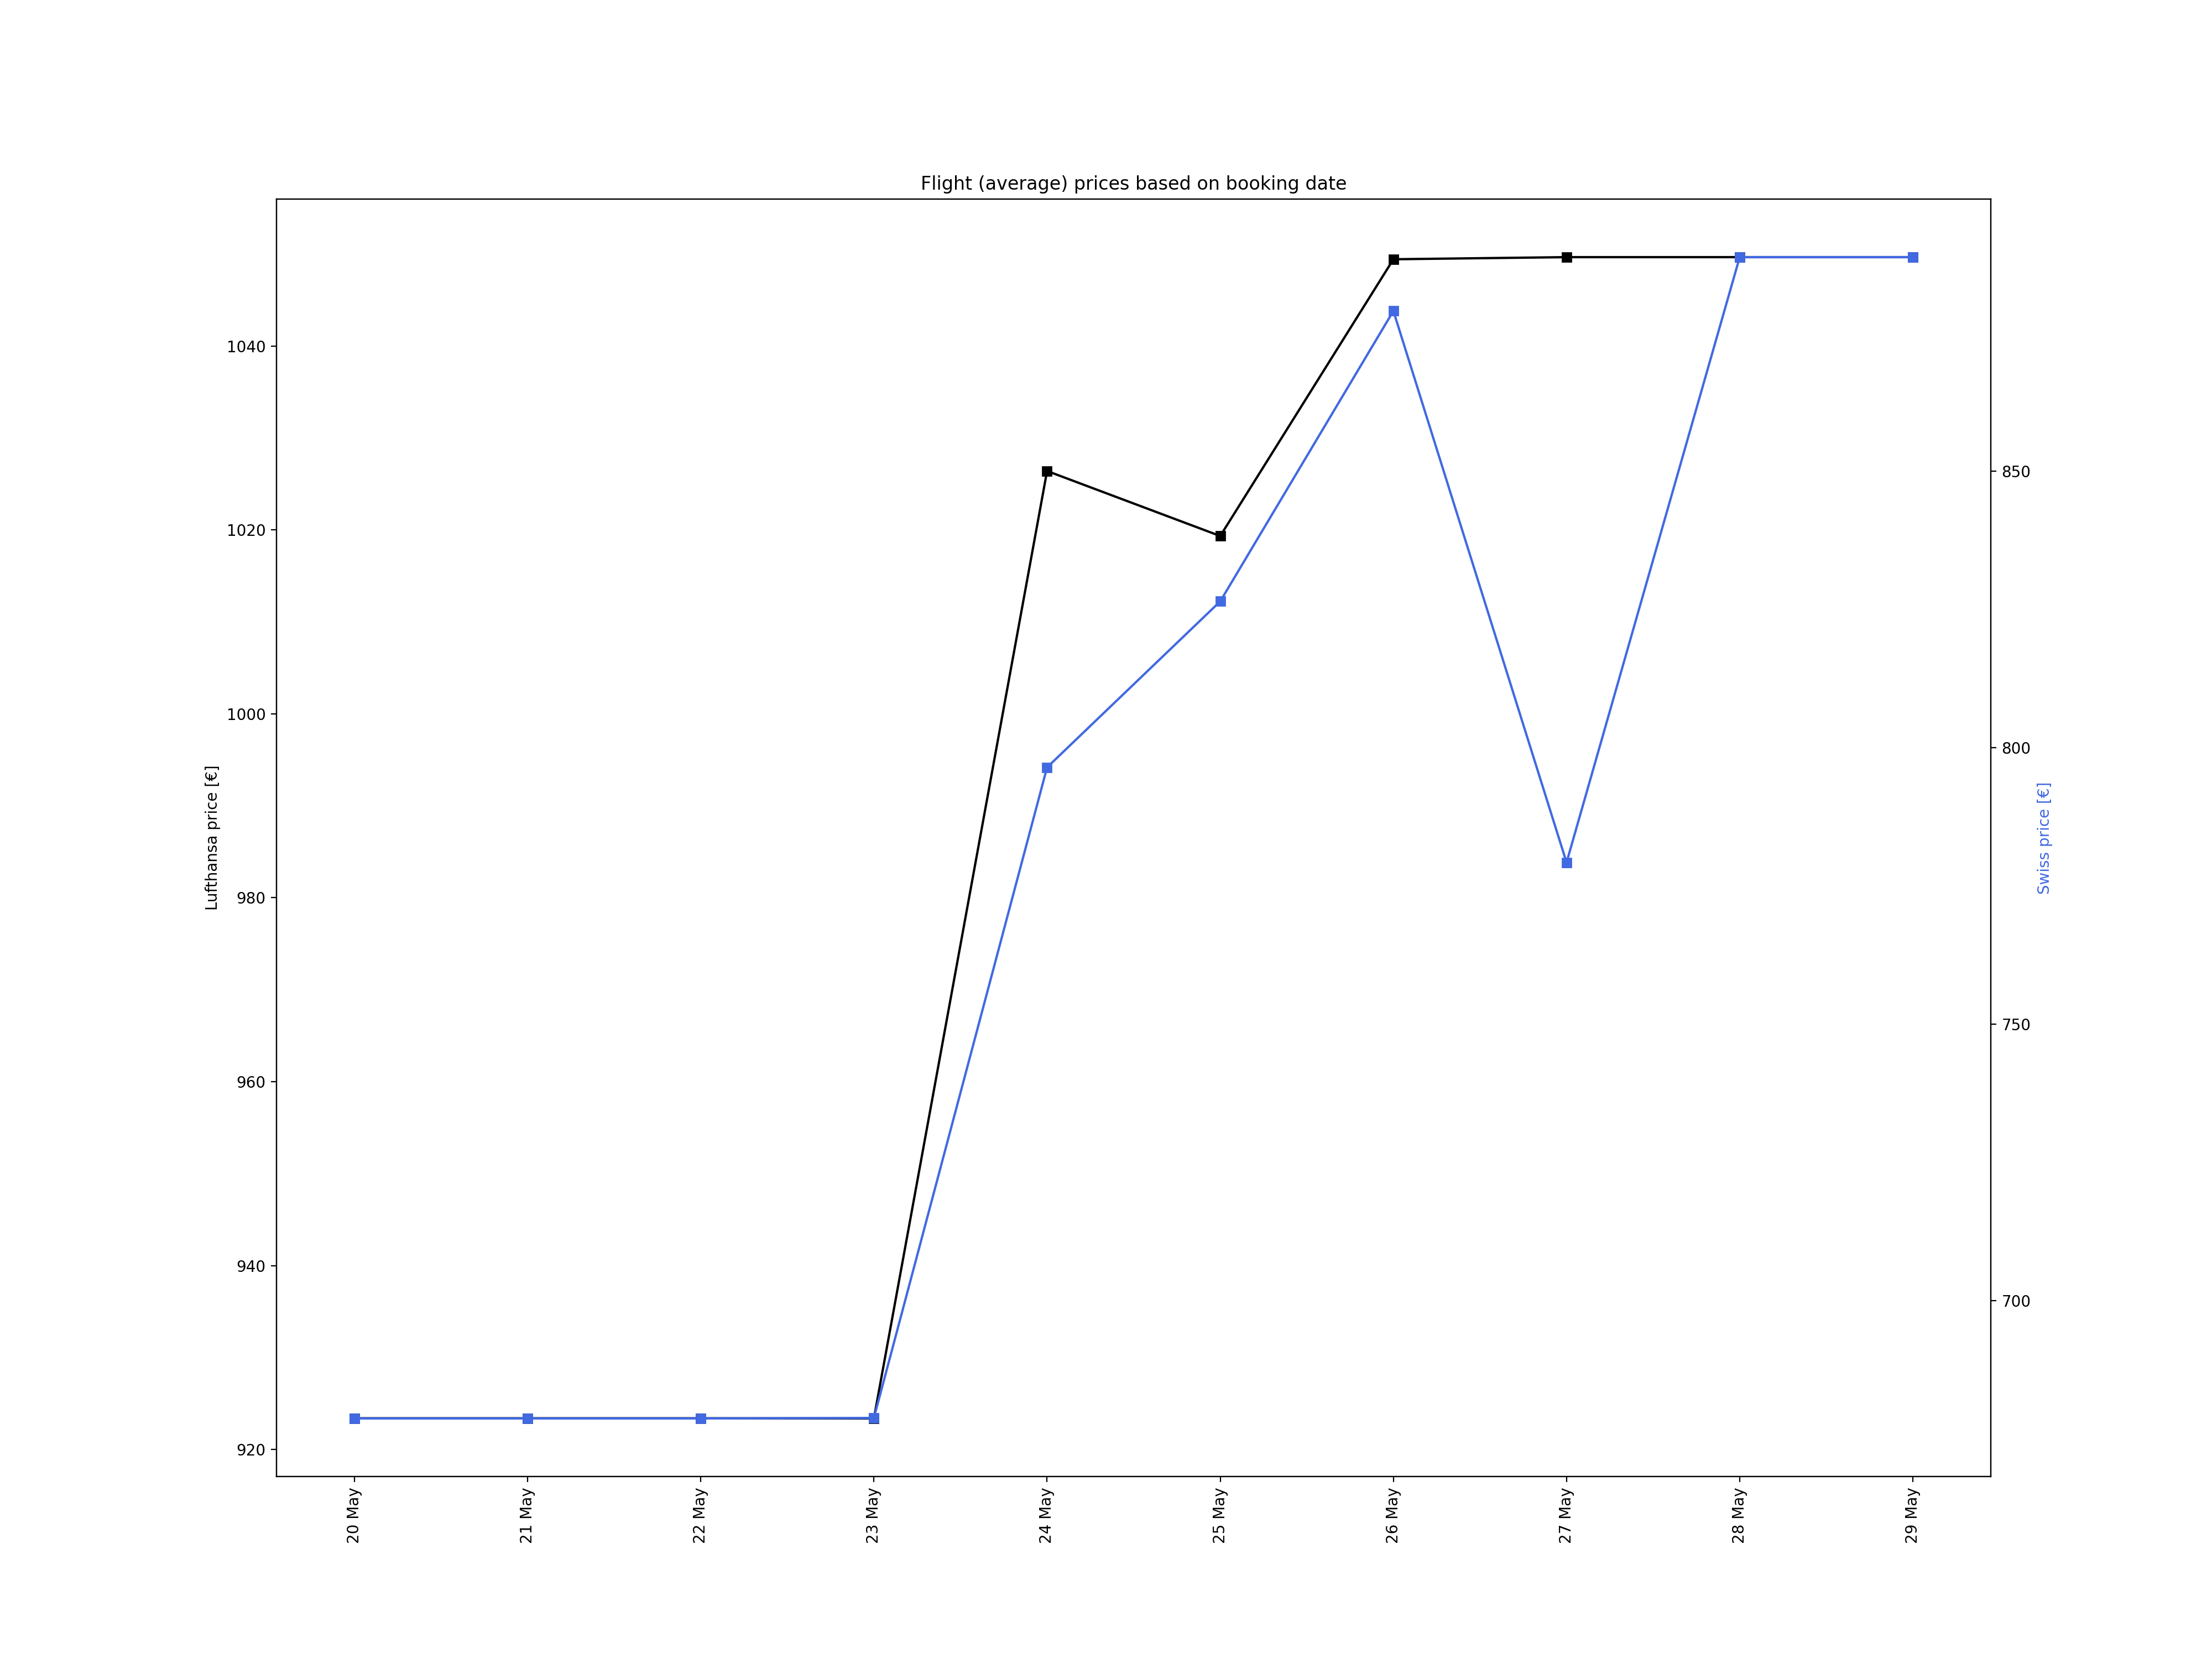

In [25]:
fig, ax1 = plt.subplots(figsize = (20,15))

ax1.plot(date_nyc, price_lufthansa_nyc, "-s", color = 'k')
plt.xticks(rotation=90)
ax1.set_ylabel("Lufthansa price [€]", color = 'k')
# ax1.fill_between(lineplot_nyc['date'], lineplot_nyc['min'], lineplot_nyc['max'], alpha=0.1)
ax2 = ax1.twinx()
ax2.plot(date_nyc, price_swiss_nyc,"-s",color = "royalblue")
ax2.set_ylabel("Swiss price [€]", color = "royalblue")
# ax2.fill_between(lineplot_nyc['date'], lineplot_nyc['min'], lineplot_nyc['max'], alpha=0.1)

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

plt.xticks(rotation=90)
plt.title('Flight (average) prices based on booking date');

#### (draft) Lineplot for New York City based on time and day of booking

In [26]:
lineplot_nyc = dataset.loc[(dataset.arr_city=='JFK')].groupby(['out_airline_company','date'])['ticket_price'].agg(['min','mean','max'])

lineplot_nyc = lineplot_nyc.reset_index()

lineplot_nyc['date'] = lineplot_nyc['date'].dt.strftime('%d %b %I %p')

In [27]:
lineplot_nyc.head()

,out_airline_company,date,min,mean,max
0,Lufthansa,20 May 04 PM,923.39,1133.220556,1198.39
1,Lufthansa,20 May 06 PM,923.39,1131.853333,1198.39
2,Lufthansa,20 May 08 PM,923.39,1105.545000,1198.39
3,Lufthansa,20 May 10 PM,923.39,1134.216111,1198.39
4,Lufthansa,21 May 08 AM,923.39,1129.710000,1198.39


In [28]:
lineplot_nyc.dtypes

out_airline_company     object
date                    object
min                    float64
mean                   float64
max                    float64
dtype: object

In [29]:
# date_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Lufthansa']['date'].tolist()
date_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Lufthansa']['date'].tolist()
price_lufthansa_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Lufthansa']['mean'].tolist()
price_swiss_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Swiss']['mean'].tolist()

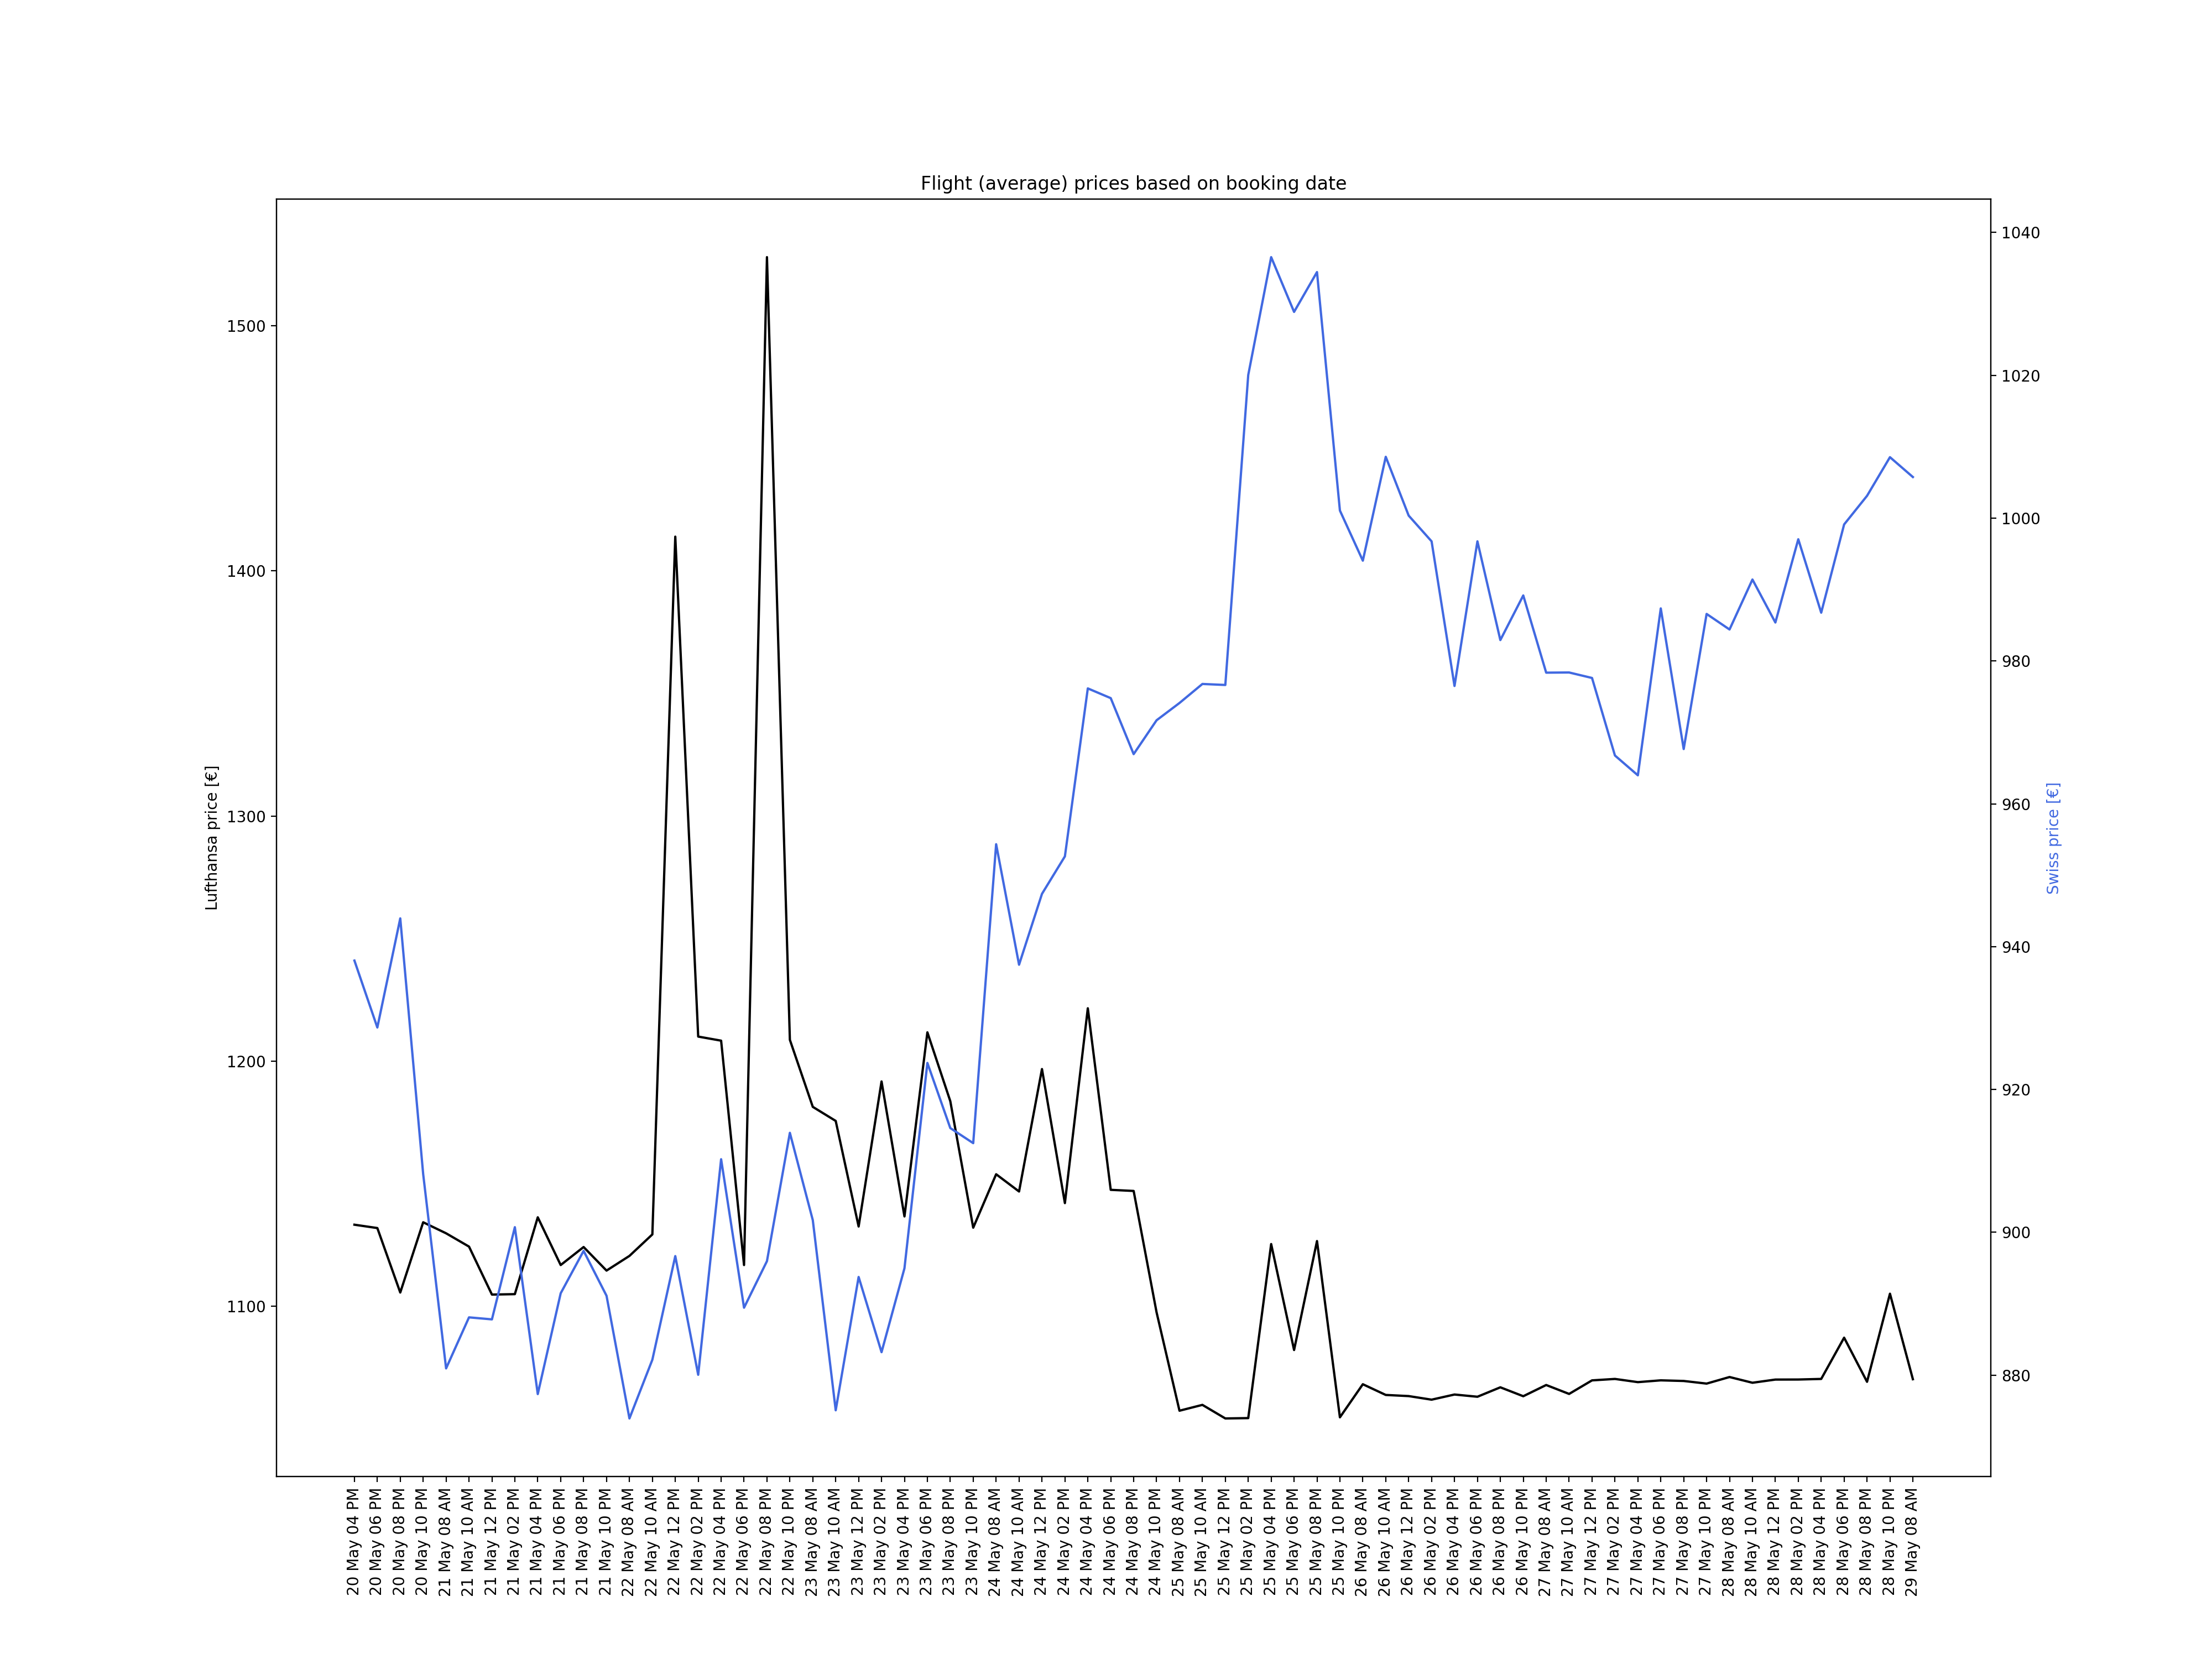

In [30]:
fig, ax1 = plt.subplots(figsize = (20,15))

ax1.plot(date_nyc, price_lufthansa_nyc, color = 'k')
plt.xticks(rotation=90)
ax1.set_ylabel("Lufthansa price [€]", color = 'k')
# ax1.fill_between(lineplot_nyc['date'], lineplot_nyc['min'], lineplot_nyc['max'], alpha=0.1)
ax2 = ax1.twinx()
ax2.plot(date_nyc, price_swiss_nyc, color = "royalblue")
ax2.set_ylabel("Swiss price [€]", color = "royalblue")
# ax2.fill_between(lineplot_nyc['date'], lineplot_nyc['min'], lineplot_nyc['max'], alpha=0.1)

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

plt.xticks(rotation=90)
plt.title('Flight (average) prices based on booking date');

#### c2. Lineplot for São Paulo based on booking day

In [31]:
lineplot_sao=lineplot.loc[(lineplot.arr_city=='GRU')].groupby(['day_booking','out_airline_company'])['ticket_price'].min()
lineplot_sao=lineplot_sao.reset_index()

In [32]:
date_sao = lineplot_sao[lineplot_sao.out_airline_company == 'Lufthansa']['day_booking'].tolist()
price_lufthansa_sao = lineplot_sao[lineplot_sao.out_airline_company == 'Lufthansa']['ticket_price'].tolist()
price_swiss_sao = lineplot_sao[lineplot_sao.out_airline_company == 'Swiss']['ticket_price'].tolist()

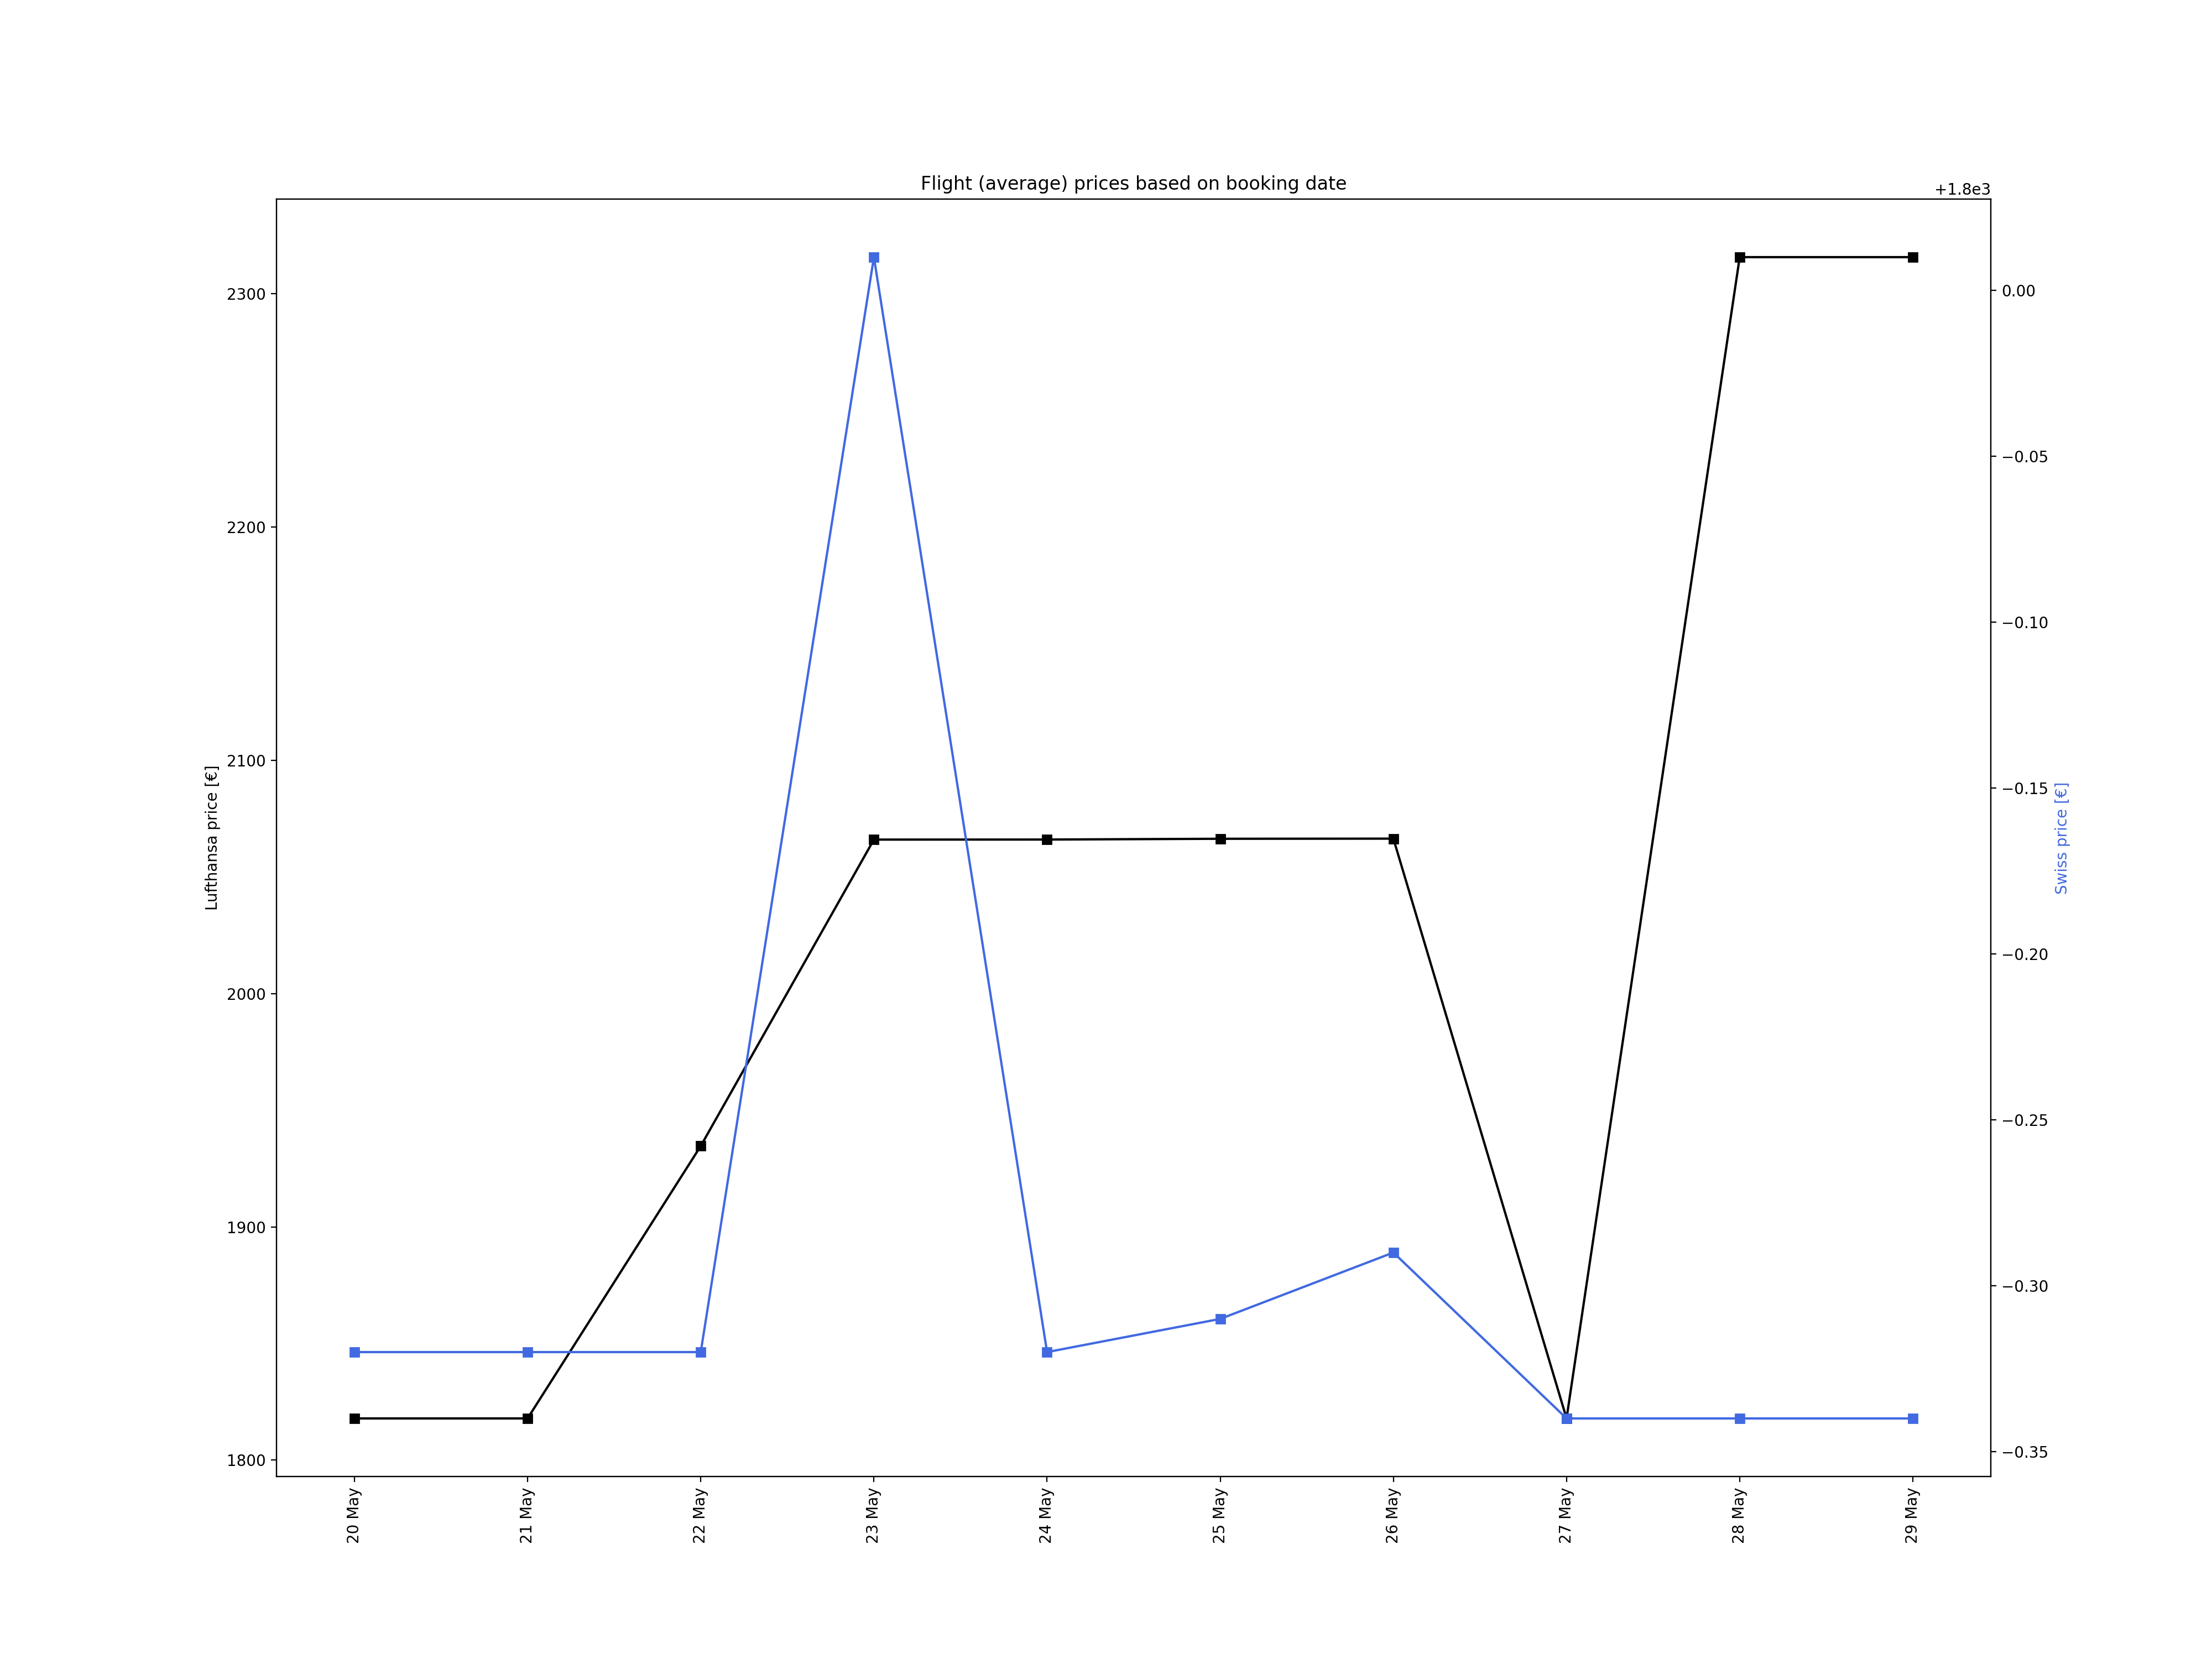

In [33]:
fig, ax1 = plt.subplots(figsize = (20,15))

ax1.plot(date_sao, price_lufthansa_sao, "-s", color = 'k')
plt.xticks(rotation=90)
ax1.set_ylabel("Lufthansa price [€]", color = 'k')
# ax1.fill_between(lineplot_nyc['date'], lineplot_nyc['min'], lineplot_nyc['max'], alpha=0.1)
ax2 = ax1.twinx()
ax2.plot(date_sao, price_swiss_sao,"-s",color = "royalblue")
ax2.set_ylabel("Swiss price [€]", color = "royalblue")
# ax2.fill_between(lineplot_nyc['date'], lineplot_nyc['min'], lineplot_nyc['max'], alpha=0.1)

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

plt.xticks(rotation=90)
plt.title('Flight (average) prices based on booking date');

#### (draft) Lineplot for São Paulo based on time and day of booking


In [34]:
lineplot_sao = dataset.loc[(dataset.arr_city=='GRU')].groupby(['out_airline_company','date'])['ticket_price'].agg(['mean'])
lineplot_sao = lineplot_sao.reset_index()
# lineplot_sao['date'] = pd.to_datetime(lineplot_sao['day_scrap'].astype(str) + ' ' + month + ' ' + year + ' '+ lineplot_sao['hour_scrap'].astype(str), format='%d %b %Y %H')
lineplot_sao['date'] = lineplot_sao['date'].dt.strftime('%d %b %I %p')

In [35]:
lineplot_sao.head()

,out_airline_company,date,mean
0,Lufthansa,20 May 04 PM,1910.573437
1,Lufthansa,20 May 06 PM,1910.573437
2,Lufthansa,20 May 08 PM,1905.350000
3,Lufthansa,20 May 10 PM,1902.225000
4,Lufthansa,21 May 08 AM,1908.475000


In [36]:
date_sao = lineplot_sao[lineplot_sao.out_airline_company == 'Lufthansa']['date'].tolist()
price_lufthansa_sao = lineplot_sao[lineplot_sao.out_airline_company == 'Lufthansa']['mean'].tolist()
price_swiss_sao = lineplot_sao[lineplot_sao.out_airline_company == 'Swiss']['mean'].tolist()

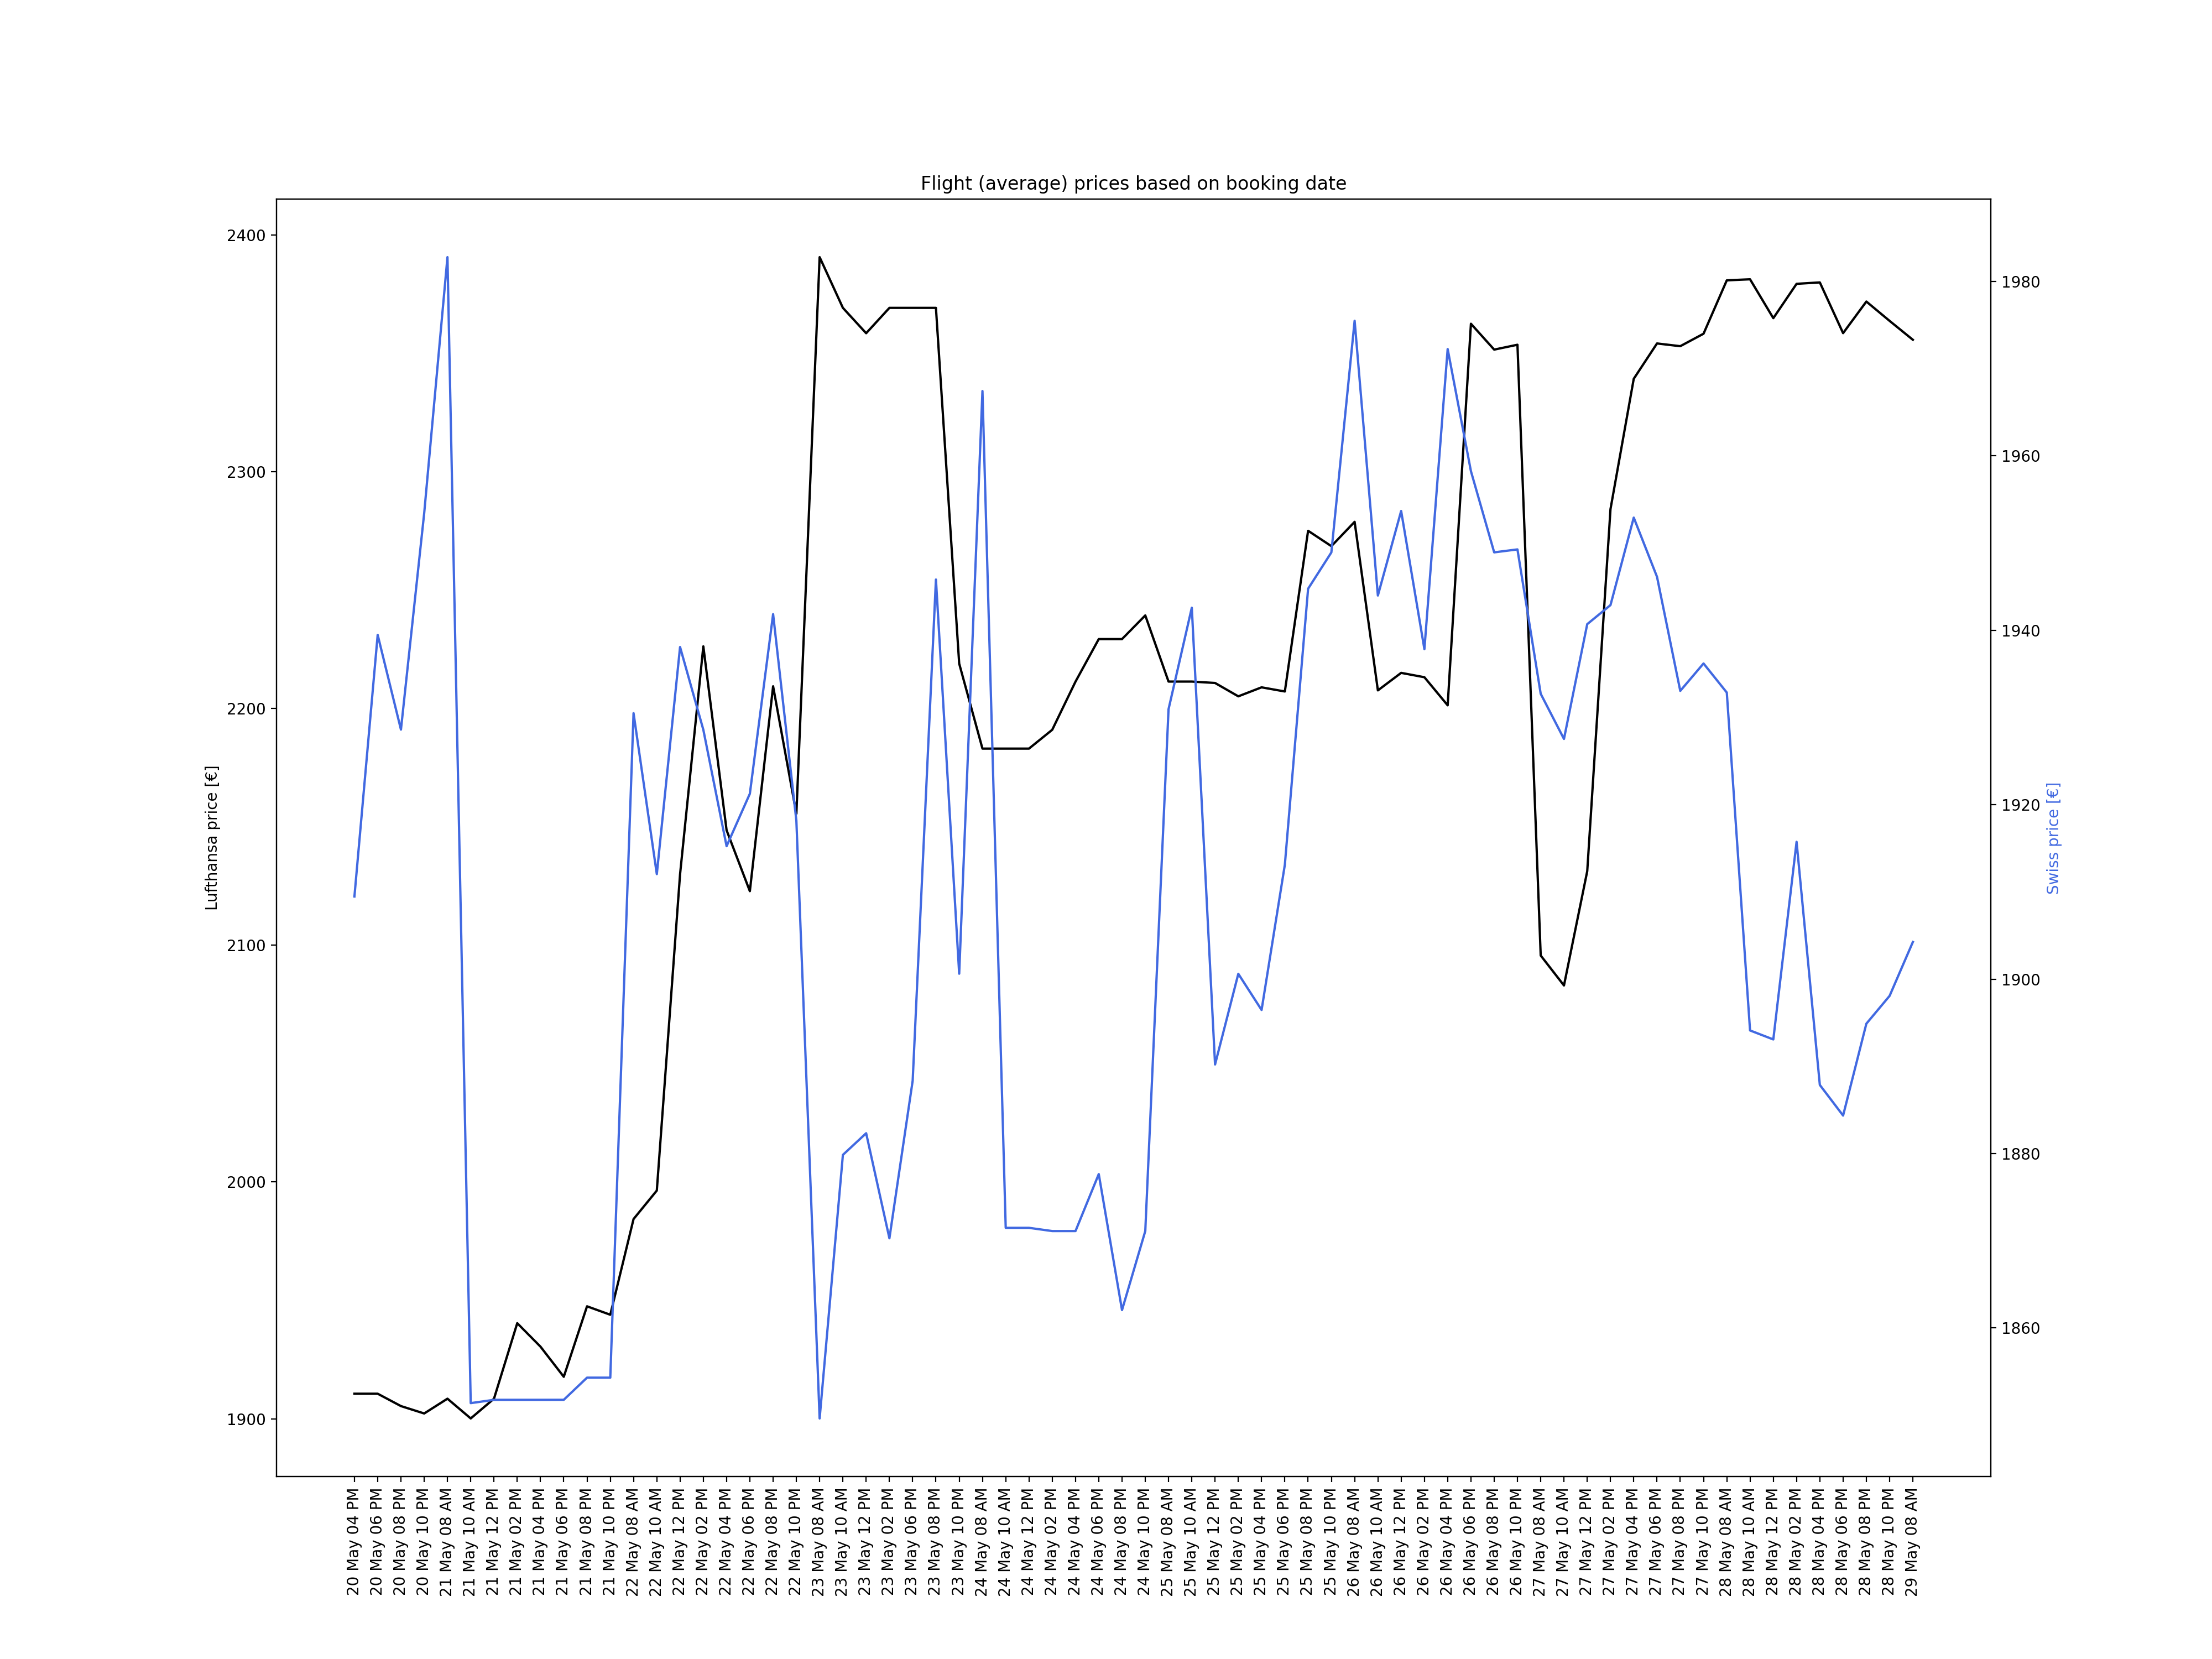

In [37]:
fig, ax1 = plt.subplots(figsize = (20,15))

ax1.plot(date_sao, price_lufthansa_sao, color = 'k')
plt.xticks(rotation=90)
ax1.set_ylabel("Lufthansa price [€]", color = 'k')
ax2 = ax1.twinx()
ax2.plot(date_sao, price_swiss_sao, color = "royalblue")
ax2.set_ylabel("Swiss price [€]", color = "royalblue")
plt.xticks(rotation=90)
plt.title('Flight (average) prices based on booking date');

## d. Scatter plot

##### d1. scatter plot for New York City

In [38]:
scatterplot_nyc = dataset.loc[(dataset.arr_city=='JFK')].groupby(['out_airline_company','tot_duration'])['ticket_price'].mean().reset_index(name='price')
scatterplot_nyc

,out_airline_company,tot_duration,price
0,Lufthansa,0 days 21:05:00,1197.999266
1,Lufthansa,0 days 21:10:00,1228.858438
2,Lufthansa,0 days 21:30:00,1150.388876
3,Lufthansa,0 days 21:35:00,1068.060476
4,Lufthansa,0 days 21:50:00,1117.021429
...,...,...,...
77,Swiss,2 days 08:55:00,771.168750
78,Swiss,2 days 09:20:00,720.120000
79,Swiss,2 days 10:10:00,745.962143
80,Swiss,2 days 12:20:00,802.640000


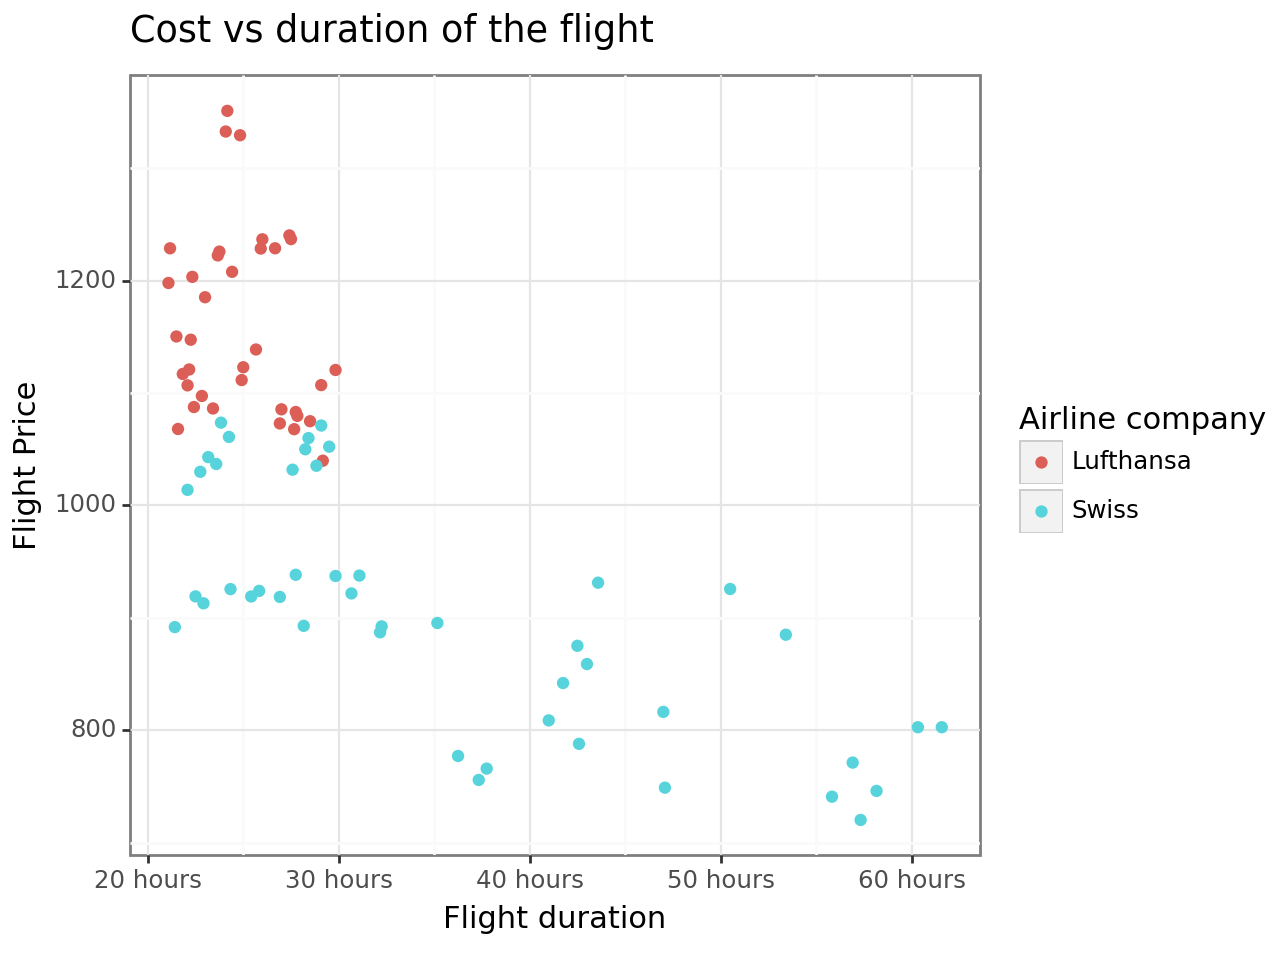

<Figure Size: (640 x 480)>

In [39]:
f6= (ggplot(scatterplot_nyc, aes(x='tot_duration', y='price', color='out_airline_company')) + \
    geom_point() + \
    labs(title='Cost vs duration of the flight',
         x='Flight duration',
         y='Flight Price',
         color='Airline company') + \
    theme_bw()
)
f6

##### d2. scatter plot for São Paulo

In [40]:
scatterplot_sao = dataset.loc[(dataset.arr_city=='GRU')].groupby(['out_airline_company','tot_duration'])['ticket_price'].mean().reset_index(name='price')
scatterplot_sao.head()

,out_airline_company,tot_duration,price
0,Lufthansa,1 days 04:25:00,2366.517647
1,Lufthansa,1 days 05:15:00,2382.895588
2,Lufthansa,1 days 06:20:00,2306.527419
3,Lufthansa,1 days 06:25:00,2342.977059
4,Lufthansa,1 days 07:10:00,2330.798148


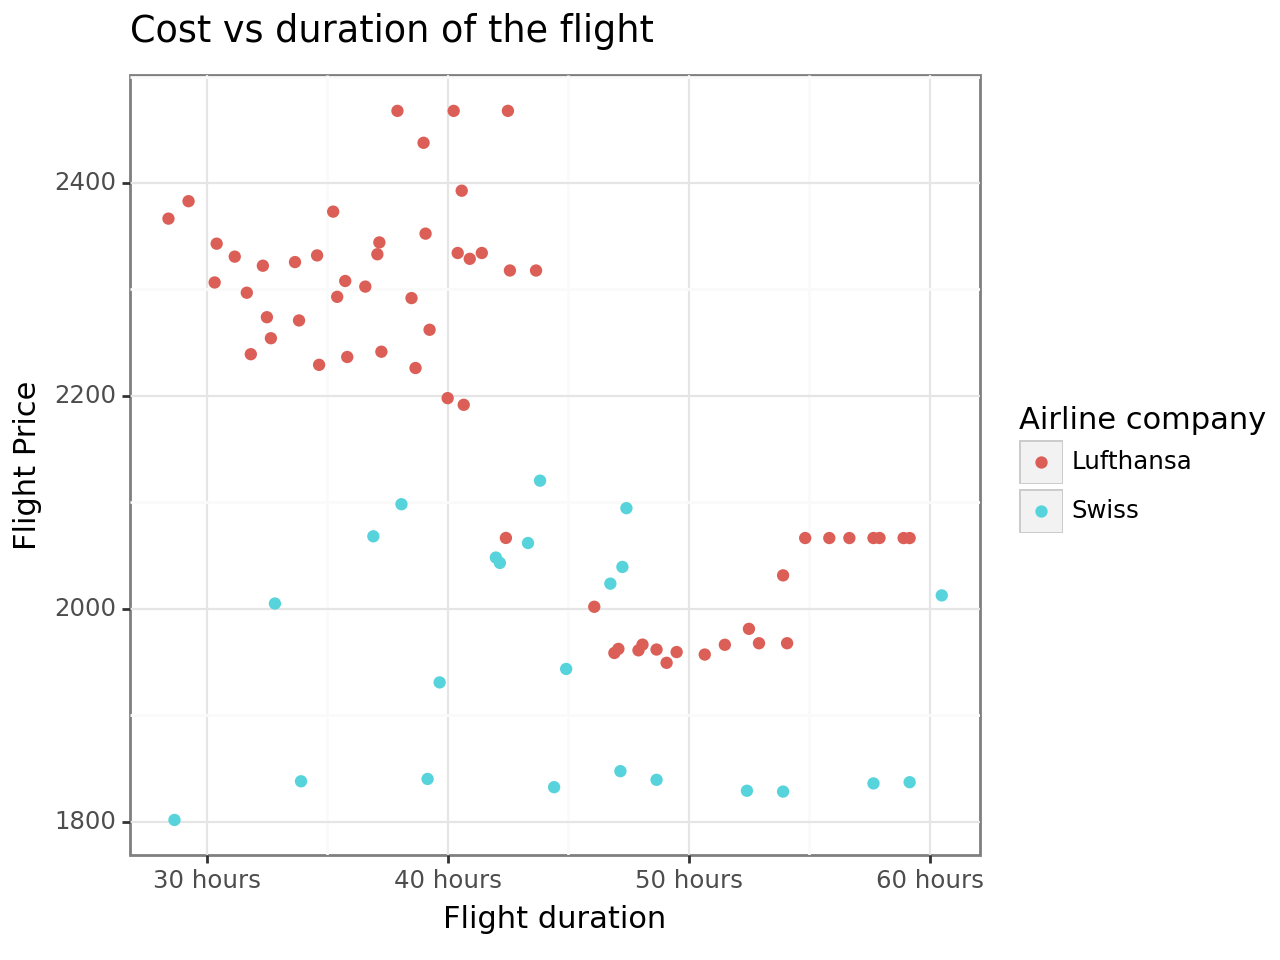

<Figure Size: (640 x 480)>

In [41]:
f7= (ggplot(scatterplot_sao, aes(x='tot_duration', y='price', color='out_airline_company')) + \
    geom_point() + \
    labs(title='Cost vs duration of the flight',
         x='Flight duration',
         y='Flight Price',
         color='Airline company') + \
    theme_bw()
)
f7

## e. Heatmap

In [42]:
heatmap = dataset[['ticket_price', 'tot_duration','out_dep_time','out_arr_time','in_dep_time','in_arr_time','date','out_stop_num','in_stop_num']]


heatmap['out_dep_time'] = pd.to_datetime(heatmap['out_dep_time'], format='%H:%M')
heatmap['out_arr_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')
heatmap['in_dep_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')
heatmap['in_arr_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')

heatmap

,ticket_price,tot_duration,out_dep_time,out_arr_time,in_dep_time,in_arr_time,date,out_stop_num,in_stop_num
0,1176.01,0 days 21:05:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
1,923.39,1 days 05:10:00,1900-01-01 13:15:00,1900-01-01 20:05:00,1900-01-01 20:05:00,1900-01-01 20:05:00,2023-05-20 16:00:00,1,1
2,1176.01,0 days 21:50:00,1900-01-01 08:50:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
3,1176.01,0 days 22:05:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
4,1176.01,0 days 22:15:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
...,...,...,...,...,...,...,...,...,...
8542,1944.57,1 days 15:40:00,1900-01-01 09:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-29 08:00:00,2,1
8543,1944.57,1 days 15:40:00,1900-01-01 09:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-29 08:00:00,2,1
8544,1799.66,1 days 23:10:00,1900-01-01 20:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-29 08:00:00,1,1
8545,2094.57,1 days 12:55:00,1900-01-01 20:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-29 08:00:00,1,2


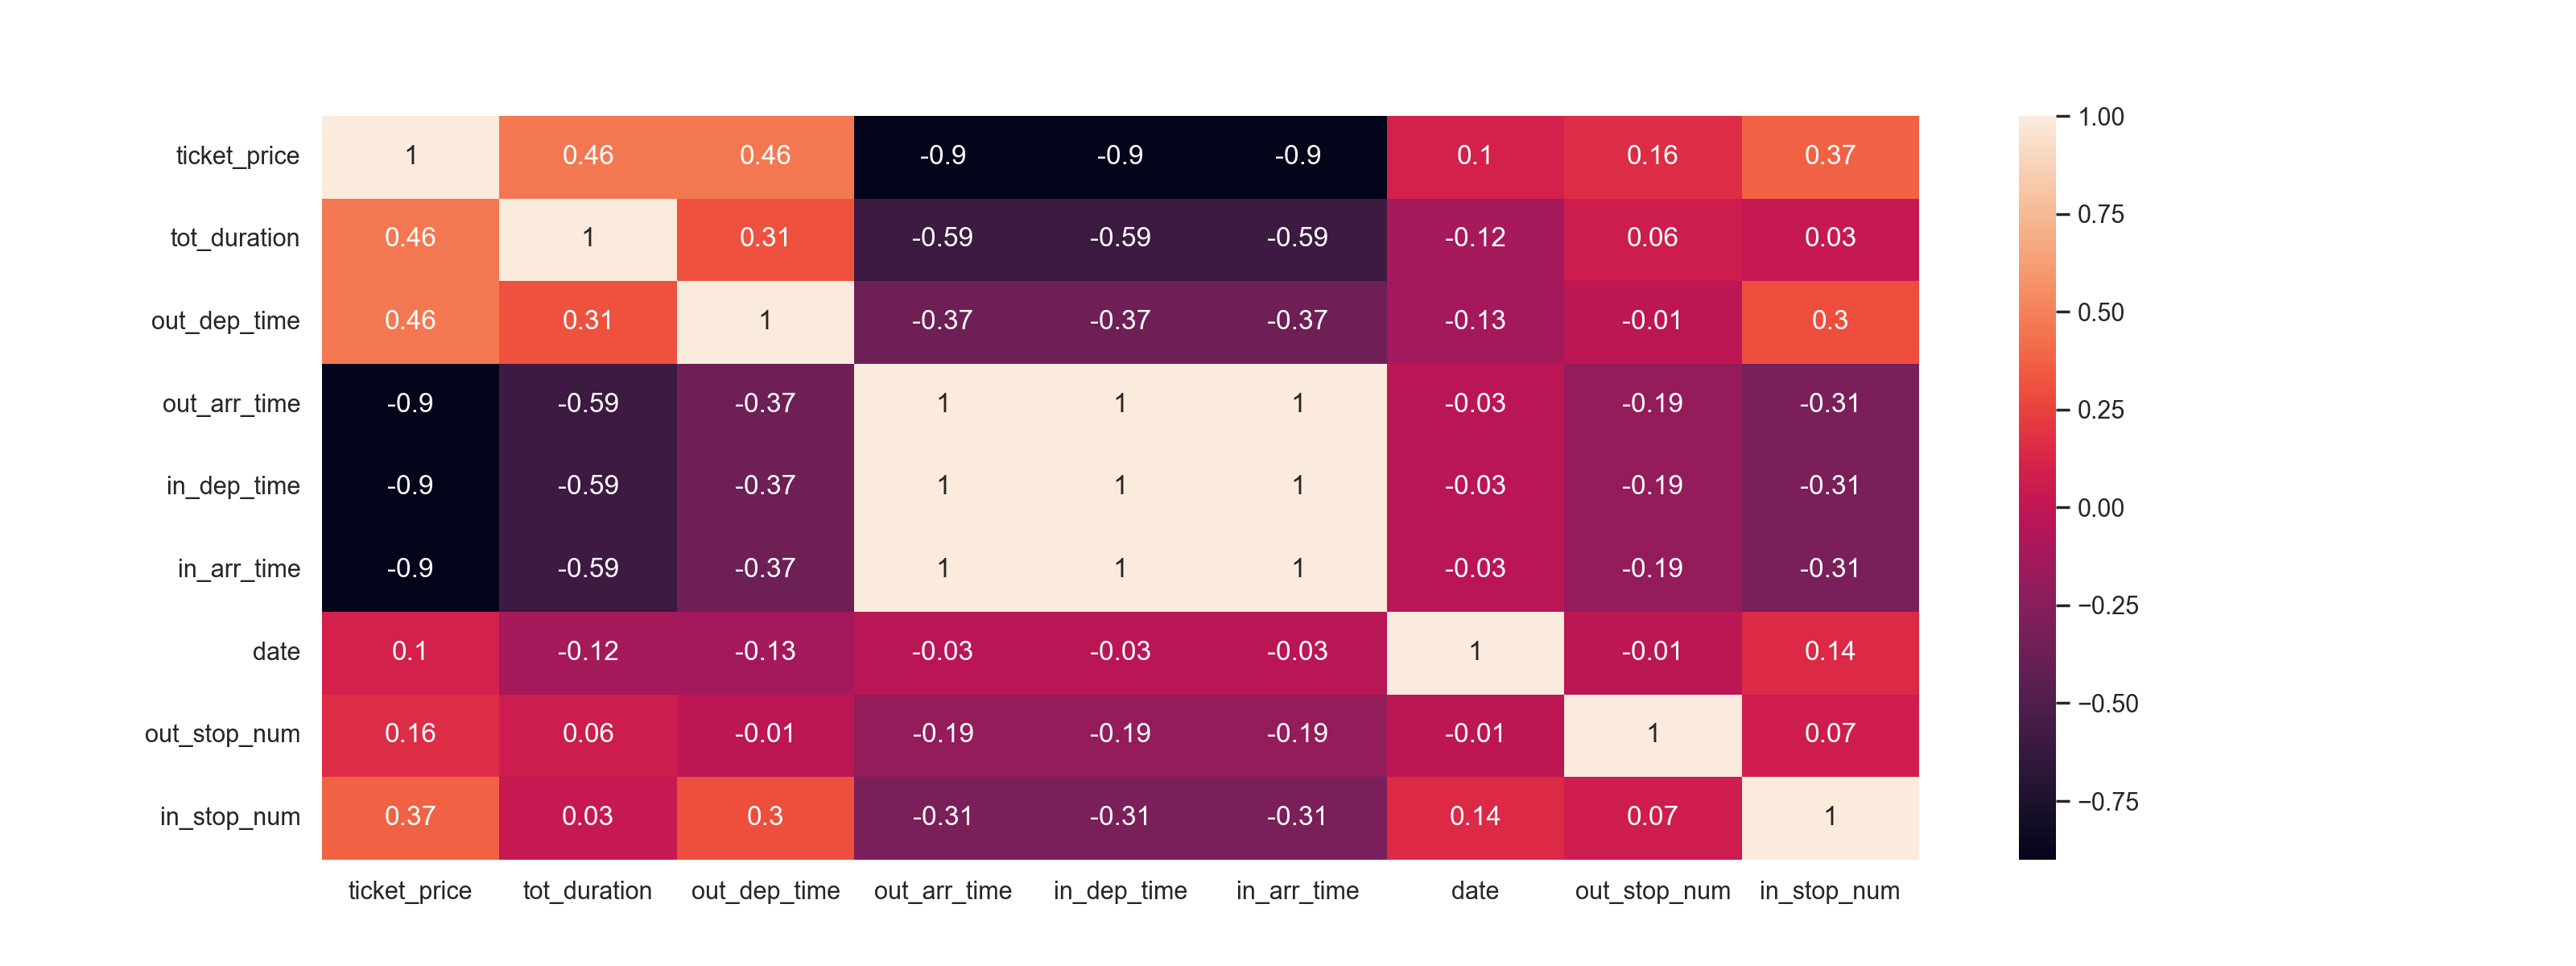

In [43]:
sns.set(rc={'figure.figsize':(16,6)})
correlation_matrix = heatmap.corr().round(2)
sns.heatmap(correlation_matrix, annot=True)
plt.show()